[*********************100%***********************]  3 of 3 completed


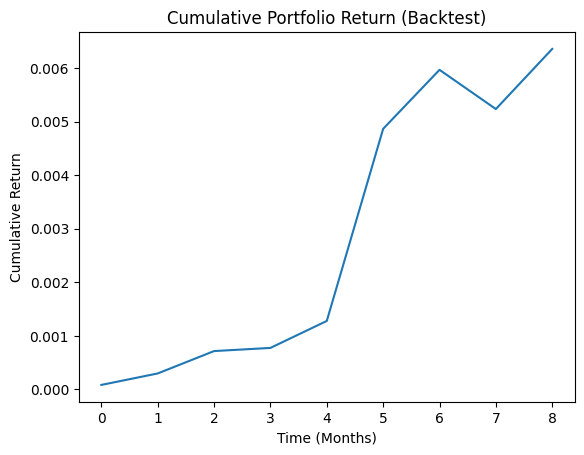

Portfolio Value at Risk (VaR) at 95% confidence: -0.00
Rebalanced portfolio weights: [4.66234379e-01 5.33765621e-01 5.70290343e-17]


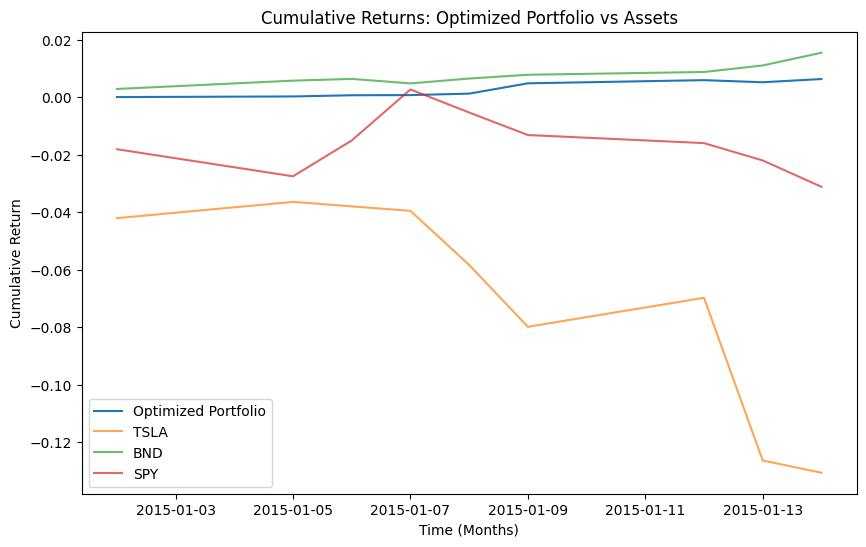

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime

# Step 1: Fetch Updated Financial Data (TSLA, BND, SPY)
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-12-31'

# Download historical data from YFinance
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Step 2: Preprocess Data to Calculate Daily Returns and Volatility
returns = data.pct_change().dropna() 
volatility = returns.std() * np.sqrt(252)  

# Calculate mean returns
mean_returns = returns.mean()

# Covariance matrix of returns
cov_matrix = returns.cov()

# Step 3: Portfolio Optimization - Maximize Sharpe Ratio
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

# Portfolio Performance Calculation
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# Step 4: Backtesting Portfolio Optimization with Rolling Window
def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    initial_guess = np.ones(num_assets) / num_assets  # Equal initial weights
    bounds = [(0.0, 1.0)] * num_assets  # Weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    
    result = minimize(negative_sharpe_ratio, initial_guess, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Rolling window backtest: re-optimize portfolio every month
window_size = 252  # Approx. one year of trading days
rolling_windows = [returns.iloc[i:i+window_size] for i in range(0, len(returns)-window_size, window_size)]

portfolio_returns = []
for window in rolling_windows:
    mean_returns = window.mean()
    cov_matrix = window.cov()
    optimal_weights = optimize_portfolio(mean_returns, cov_matrix)
    
    # Calculate portfolio performance
    portfolio_return, portfolio_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
    portfolio_returns.append(portfolio_return)

# Step 5: Evaluate Portfolio Performance (Cumulative Return, Risk, Sharpe Ratio)
cumulative_returns = np.cumsum(portfolio_returns)

# Plot cumulative returns
plt.plot(cumulative_returns)
plt.title("Cumulative Portfolio Return (Backtest)")
plt.xlabel("Time (Months)")
plt.ylabel("Cumulative Return")
plt.show()

# Step 6: Value at Risk (VaR) Calculation for Portfolio
confidence_interval = 0.05  # 95% confidence interval for VaR
VaR = np.percentile(portfolio_returns, confidence_interval * 100)
print(f"Portfolio Value at Risk (VaR) at 95% confidence: {VaR:.2f}")

# Step 7: Portfolio Rebalancing (Real-Time Adjustments)
# In a real-time scenario, we rebalance the portfolio periodically, 
def rebalance_portfolio(current_data, forecasted_trends):
    # Re-optimize portfolio based on updated data
    mean_returns = current_data.mean()
    cov_matrix = current_data.cov()
    optimal_weights = optimize_portfolio(mean_returns, cov_matrix)
    return optimal_weights

# Simulating rebalancing with updated returns over the past month (rolling monthly window)
recent_data = returns.tail(252)  
rebalance_weights = rebalance_portfolio(recent_data, forecasted_trends=None)  
print(f"Rebalanced portfolio weights: {rebalance_weights}")

# Step 8: Generate Performance Report (Cumulative Return, Risk, Sharpe Ratio)
portfolio_sharpe_ratio = np.mean(portfolio_returns) / np.std(portfolio_returns)

performance_report = pd.DataFrame({
    'Cumulative Return': cumulative_returns,
    'Portfolio Volatility': [portfolio_volatility] * len(cumulative_returns),
    'Sharpe Ratio': [portfolio_sharpe_ratio] * len(cumulative_returns)
})

# Save the performance report to a CSV file
performance_report.to_csv("portfolio_performance_report.csv", index=False)

# Step 9: Visualize Portfolio Adjustments
# Visualizing portfolio performance vs individual asset performance
plt.figure(figsize=(10, 6))
plt.plot(data.index[:len(cumulative_returns)], cumulative_returns, label="Optimized Portfolio")
plt.plot(data.index[:len(cumulative_returns)], np.cumsum(returns['TSLA'][:len(cumulative_returns)]), label="TSLA", alpha=0.7)
plt.plot(data.index[:len(cumulative_returns)], np.cumsum(returns['BND'][:len(cumulative_returns)]), label="BND", alpha=0.7)
plt.plot(data.index[:len(cumulative_returns)], np.cumsum(returns['SPY'][:len(cumulative_returns)]), label="SPY", alpha=0.7)

plt.title("Cumulative Returns: Optimized Portfolio vs Assets")
plt.xlabel("Time (Months)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


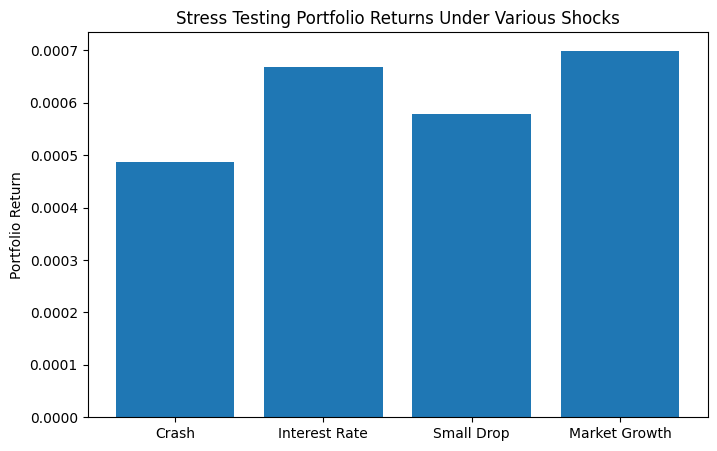

In [ ]:
#Stress Testing and Scenario Analysis
def stress_test_portfolio(returns, shocks):
    """
    Simulate portfolio performance under different shocks or stress scenarios.
    
    Args:
        returns (pd.DataFrame): Historical asset returns.
        shocks (list): A list of shocks to apply to asset returns, represented as a percentage change.
    
    Returns:
        stressed_portfolio_returns (pd.Series): Portfolio returns under the applied stress scenarios.
    """
    stressed_portfolio_returns = []
    for shock in shocks:
        # Apply the shock to the returns data (e.g., market crash scenario)
        stressed_returns = returns * (1 + shock / 100)
        portfolio_return = np.sum(stressed_returns.mean() * optimal_weights)
        stressed_portfolio_returns.append(portfolio_return)
    
    return pd.Series(stressed_portfolio_returns)

# Example: Simulate a 20% market crash, a 10% interest rate hike, etc.
shocks = [-20, 10, -5, 15]
stressed_returns = stress_test_portfolio(returns, shocks)

# Plot results
plt.figure(figsize=(8, 5))
plt.bar(range(len(shocks)), stressed_returns, tick_label=["Crash", "Interest Rate", "Small Drop", "Market Growth"])
plt.title("Stress Testing Portfolio Returns Under Various Shocks")
plt.ylabel("Portfolio Return")
plt.show()
